In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import bayesian_model as bm
import emcee
import corner

In [2]:
data = pd.read_csv('dielectron.csv')

data = data.dropna()
data = data[(data['Q1'] + data['Q2']) == 0]

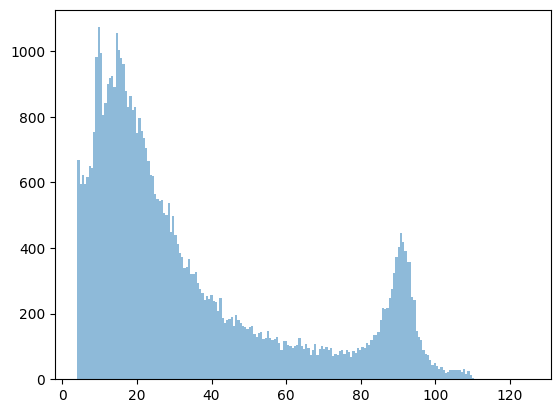

In [3]:
M_data = data['M'].values
plt.hist(M_data, bins=200, range=(4, 125), alpha=0.5, label='Data')

hist, bin_edges = np.histogram(M_data, bins=200, range=(4,125))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

y = hist
x = bin_centers

In [4]:
a1_prior = scipy.stats.norm(loc=410, scale=100)
mu1_prior = scipy.stats.norm(loc=91, scale=10)
sigma1_prior = scipy.stats.norm(loc=3, scale=3)

a2_prior = scipy.stats.norm(loc=700, scale=200)
mu2_prior = scipy.stats.norm(loc=15, scale=10)
sigma2_prior = scipy.stats.norm(loc=7.5, scale=3)

b_prior = scipy.stats.norm(loc=380, scale=150)
k_prior = scipy.stats.norm(loc=0.025, scale=0.015)

priors = [a1_prior, mu1_prior, sigma1_prior, a2_prior, mu2_prior, sigma2_prior, b_prior, k_prior]


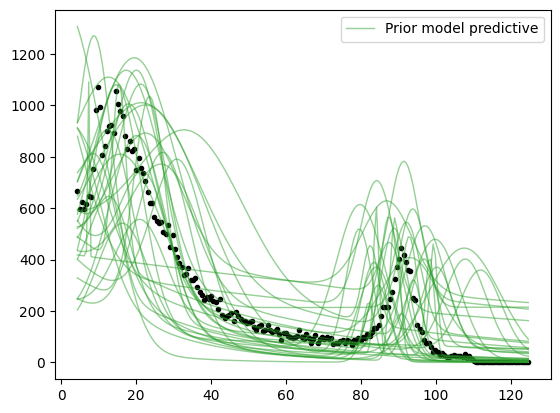

In [5]:
# Fix the pseudo random number generator seed for reproducibility
np.random.seed(1)

# Evaluate the model at the prior sample parameters
prior_model_predictive = np.array(
    [bm.model_gauss_exp(x, *parameters) for parameters in bm.sample_prior(n_sample=30, priors=priors)]
)

style = dict(c="C2", lw=1, alpha=0.5)
plt.plot(x, y, '.', color = 'black')
plt.plot(x, prior_model_predictive.T, **style)
plt.plot([], [], label="Prior model predictive", **style)
plt.legend()

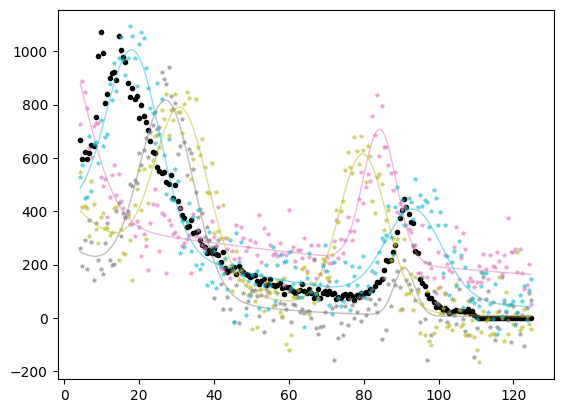

In [6]:
sigma_y = 70
prior_predictive = (
    prior_model_predictive
    + sigma_y*np.random.normal(size=prior_model_predictive.shape)
)

pmp_style = dict(lw=1, alpha=0.5)
pp_style = dict(ls="none", marker="*", ms=3, alpha=0.5)

plt.plot(x, y, ".", color = 'black')

for i in range(4, 8):
    plt.plot(x, prior_model_predictive[i], c=f"C{i+2}", **pmp_style)
    plt.plot(x, prior_predictive[i], c=f"C{i+2}", **pp_style)

MAP results
[3.52507752e+02 9.08079297e+01 3.08488227e+00 5.77612150e+02
 1.62412847e+01 8.69111104e+00 4.87892161e+02 2.31631922e-02]


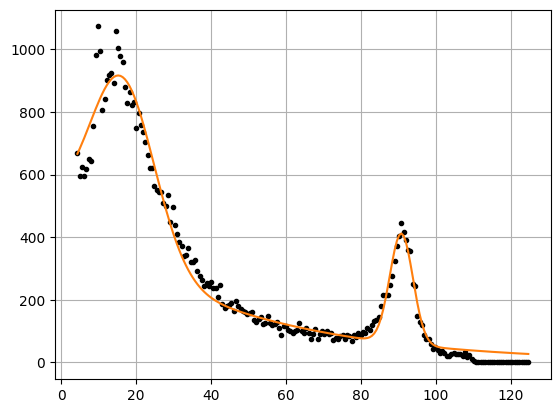

In [7]:
MAP_result = scipy.optimize.minimize(
    fun=bm.negative_log_posterior,
    x0=(410, 91, 3, 700, 15, 7.5, 380, 0.025),
    args=(x, y, sigma_y, bm.model_gauss_exp, priors)
)
MAP_results = MAP_result.x


print("MAP results")
print(MAP_results)

plt.plot(x, y, '.', color = 'black')
plt.plot(x, bm.model_gauss_exp(x, *MAP_results), c="C1", label="MAP model")
plt.grid()


### Now sampling using emcee MCMC chains

In [10]:
np.random.seed(4)

# emcee requires some extra settings to run
n_param = 8       # Number of parameter we are sampling
n_walker = 30     # Number of walkers. This just needs to be 
                  # larger than 2*n_param + 1!
n_step = 10000     # How many steps each walker will take. The number
                  # of samples will be n_walker*n_step

# The starting point for each walker
# theta_init = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]) \
#     + 0.1*np.random.normal(size=(n_walker, n_param))
    
theta_init = np.column_stack([
    a1_prior.rvs(size=n_walker),
    mu1_prior.rvs(size=n_walker),
    sigma1_prior.rvs(size=n_walker),
    a2_prior.rvs(size=n_walker),
    mu2_prior.rvs(size=n_walker),
    sigma2_prior.rvs(size=n_walker),
    b_prior.rvs(size=n_walker),
    k_prior.rvs(size=n_walker)
])

sampler = emcee.EnsembleSampler(
    nwalkers=n_walker, ndim=n_param,
    log_prob_fn=bm.log_posterior_probability,
    args=(x, y, sigma_y, bm.model_gauss_exp, priors)
)
state = sampler.run_mcmc(theta_init, nsteps=n_step)


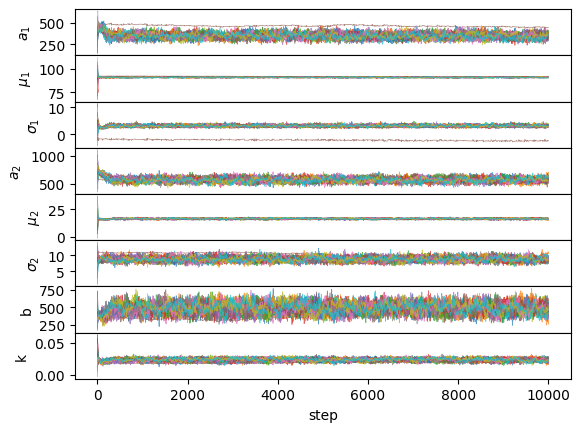

In [8]:
chain = np.load('emcee_chain_gauss_exp_30_walker_2_10k.npy')
#chain = sampler.get_chain()

n_walker = 30
param_names = [r"$a_1$", r"$\mu_1$", r"$\sigma_1$", r"$a_2$", r"$\mu_2$", r"$\sigma_2$", "b", "k"]

# Plot the tracer of the chain, this time for all the walkers
fig, ax = plt.subplots(len(param_names), 1, sharex=True)
plt.subplots_adjust(hspace=0)

for i, name in enumerate(param_names):
    for j in range(n_walker):
        ax[i].plot(chain[:, j, i], lw=0.5, alpha=0.7, color=f"C{j}")
    ax[i].set_ylabel(name)

ax[-1].set_xlabel("step");

### Integration time - quantitative check

In [9]:
tau = emcee.autocorr.integrated_time(chain)
print("Integrated auto-correlation time")
for name, iat in zip(param_names, tau):
 print(f"{name}: {iat:.1f}")


Integrated auto-correlation time
$a_1$: 115.3
$\mu_1$: 79.1
$\sigma_1$: 84.8
$a_2$: 147.6
$\mu_2$: 107.3
$\sigma_2$: 124.8
b: 139.2
k: 133.6


#### Discard the burnout

In [11]:
max_autocorr = max(tau)
burn_in = int(10*max_autocorr)
thin = int(max_autocorr/2)

n_param = 8
chain = chain[burn_in::thin].reshape(-1, n_param)

#chain = sampler.get_chain(discard=1500, thin=10, flat=True)


#### Now the corner plots for the "filtered" chain

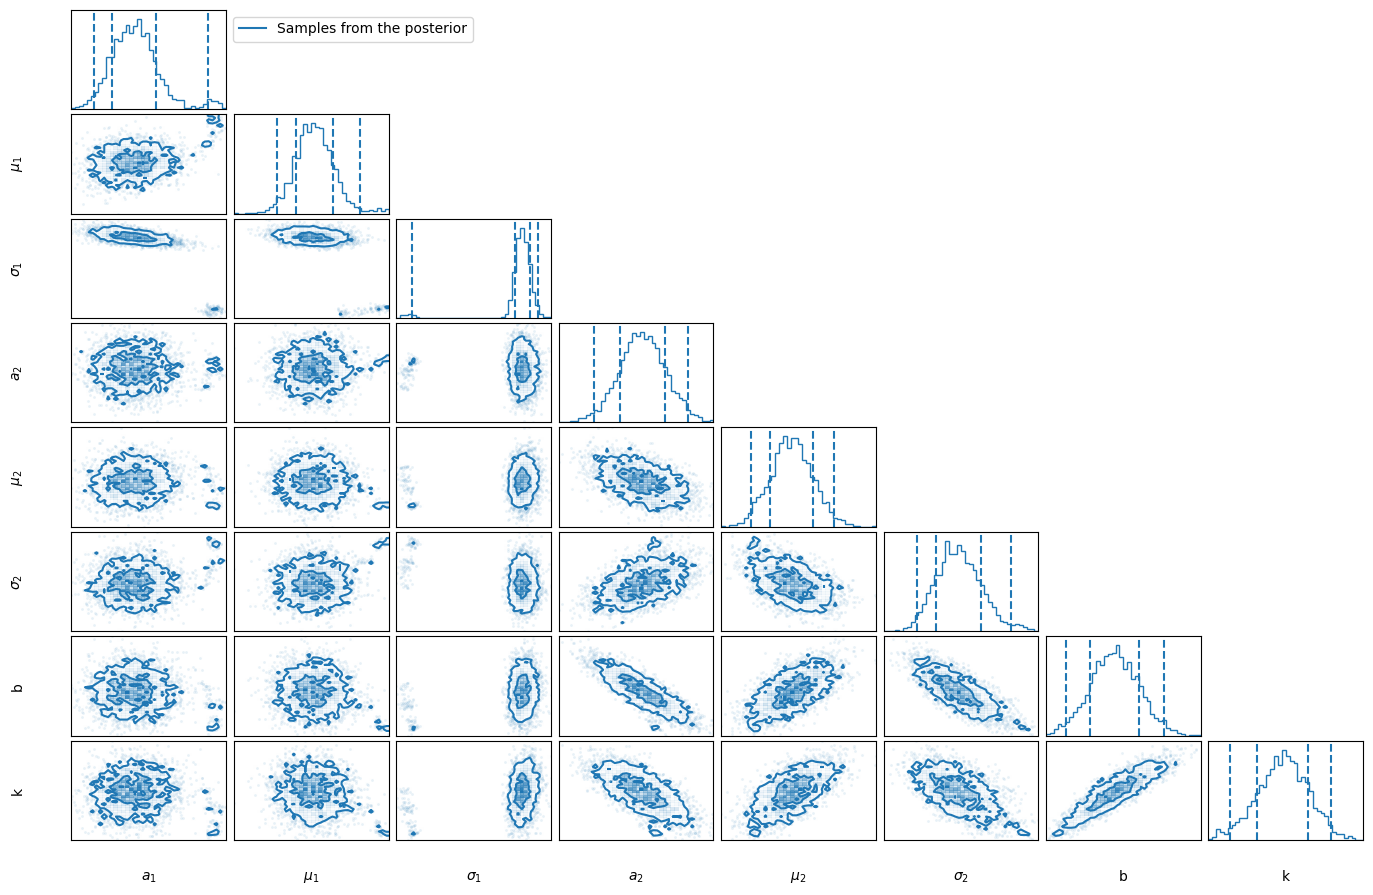

In [12]:
fig = plt.figure()
fig = corner.corner(
    chain,
    bins=40,
    labels=[r"$a_1$", r"$\mu_1$", r"$\sigma_1$", r"$a_2$", r"$\mu_2$", r"$\sigma_2$", "b", "k"],
    color="C0",
    levels=1-np.exp(-0.5*np.array([1, 2])**2), # Credible contours corresponding
                                               # to 1 and 2 sigma in 2D
    quantiles=[0.025, 0.16, 0.84, 0.975],
    fig=fig
)
fig.get_axes()[0].plot([], [], c="C0", label="Samples from the posterior")
#fig.get_axes()[0].plot([], [], c="C1", label="True parameters")
fig.get_axes()[0].legend(loc=2, bbox_to_anchor=(1, 1))

# for ax in fig.get_axes():
#     ax.xaxis.label.set_size(12)  # Optional: Adjust font size if needed
#     ax.yaxis.label.set_size(12)
#     ax.xaxis.labelpad = 30       # Adjust label padding for x-axis
#     ax.yaxis.labelpad = 30       # Adjust label padding for y-axis

for ax in fig.get_axes():
    ax.tick_params(axis="both", which="both", length=0)  # Remove tick marks
    ax.set_xticklabels([])  # Remove x-axis tick labels
    ax.set_yticklabels([])  # Remove y-axis tick labels

fig.set_size_inches(14, 9)



#### Check how the samples look

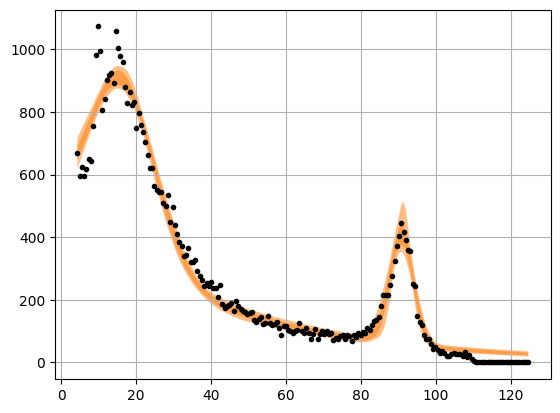

In [13]:
# Choose a small subsample of the chain for plotting purposes
#chain = np.load('emcee_chain_gauss_exp_30_walker_1.npy')
#chain = bm.process_chain(chain, discard=1000, thin=10, flat=True)

model_predictive = bm.sample_posterior(x, y, chain, bm.model_gauss_exp)


### Chi-squared goodness of fit

In [16]:
def chi_squared(y, sigma_y, mu):
    return np.sum((y - mu)**2/sigma_y**2)

chi_squared_gauss_exp = chi_squared(y, sigma_y, bm.model_gauss_exp(*MAP_results, x))

n_data = len(y)

PTE = scipy.stats.chi2(df=n_data - n_param).sf(chi_squared_gauss_exp)

print(f"Gauss + Exp: χ²={chi_squared_gauss_exp:.1f}, "
 f"ndof={n_data}-{n_param}, PTE={PTE:.3f}")


Gauss + Exp: χ²=4526.1, ndof=200-8, PTE=0.000


#### Save the not filtered chain if satisfied

In [16]:
np.save('emcee_chain_gauss_exp_30_walker_2_10k.npy', sampler.get_chain())